In [1]:
import os

import torch

from src.agents import DiscreteActorCritic
from src.networks import DiscreteActorCriticNetwork
from src.pv_env import History, PVEnvDiscrete
from src.reward import RewardDeltaPower

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_TRAIN_PATH = os.path.join("data", "weather_sim.csv")
WEATHER_TEST_PATH = os.path.join("data", "weather_real.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "02_mppt_ac.tar")
LEARNING_RATE = 0.01
ENTROPY_BETA = 0.01
GAMMA = 0.9
N_STEPS = 1
BATCH_SIZE = 16

In [2]:
env = PVEnvDiscrete.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
    actions=[-1, -0.1, 0, 0.1, 1],
)
test_env = PVEnvDiscrete.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(2, 1),
    actions=[-1, -0.1, 0, 0.1, 1],
)
device = torch.device("cpu")
net = DiscreteActorCriticNetwork(
    input_size=env.observation_space.shape[0], n_actions=env.action_space.n
).to(device)
agent = DiscreteActorCritic(
    env=env,
    test_env=test_env,
    net=net,
    device=device,
    gamma=GAMMA,
    beta_entropy=ENTROPY_BETA,
    lr=LEARNING_RATE,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    # chk_path=AGENT_CKP_PATH,
    chk_path=None,
)

INFO 2020-11-16 09:53:40,320 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-16 09:53:40,322 Starting MATLAB engine . . .
INFO 2020-11-16 09:53:44,751 MATLAB engine initializated.
INFO 2020-11-16 09:54:04,866 Model loaded succesfully.
INFO 2020-11-16 09:54:04,874 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-16 09:54:04,876 Reading data\weather_sim.csv . . .
INFO 2020-11-16 09:54:04,887 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-16 09:54:04,888 Starting MATLAB engine . . .
INFO 2020-11-16 09:54:10,120 MATLAB engine initializated.
INFO 2020-11-16 09:54:31,744 Model loaded succesfully.
INFO 2020-11-16 09:54:31,753 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-16 09:54:31,754 Reading data\weather_sim.csv . . .


In [4]:
agent.learn(steps=5000, verbose_every=100, save_every=0)

  2%|▏         | 105/5000 [00:02<01:40, 48.77it/s]
 100: loss=1.041460,  mean reward=0.11,  steps/ep=833,  episodes=1
  4%|▍         | 206/5000 [00:04<01:37, 49.14it/s]
 200: loss=0.100802,  mean reward=39.99,  steps/ep=833,  episodes=3
  6%|▌         | 307/5000 [00:06<01:33, 50.04it/s]
 300: loss=0.109665,  mean reward=63.69,  steps/ep=833,  episodes=5
  8%|▊         | 407/5000 [00:08<01:33, 48.97it/s]
 400: loss=0.682841,  mean reward=78.35,  steps/ep=833,  episodes=7
 10%|█         | 505/5000 [00:10<01:31, 49.05it/s]
 500: loss=0.989609,  mean reward=84.52,  steps/ep=833,  episodes=9
 12%|█▏        | 609/5000 [00:12<01:29, 49.16it/s]
 600: loss=-0.050115,  mean reward=88.92,  steps/ep=833,  episodes=11
 14%|█▍        | 706/5000 [00:14<01:29, 48.19it/s]
 700: loss=0.002861,  mean reward=93.60,  steps/ep=833,  episodes=13
 16%|█▌        | 809/5000 [00:16<01:26, 48.36it/s]
 800: loss=1.067344,  mean reward=96.73,  steps/ep=833,  episodes=15
 18%|█▊        | 904/5000 [00:18<01:23, 48.81

INFO 2020-11-16 09:56:48,927 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 718.91it/s]
INFO 2020-11-16 09:56:50,090 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 139054.28it/s]


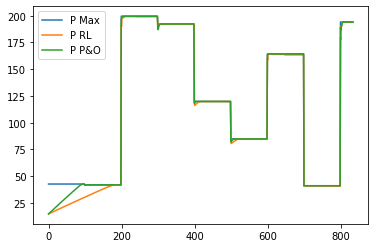

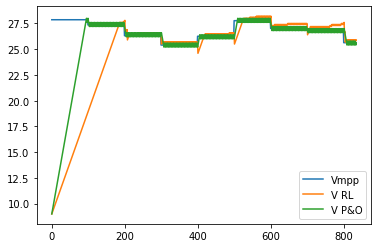

INFO 2020-11-16 09:56:50,749 PO Efficiency=96.37724791186407
INFO 2020-11-16 09:56:50,750 RL Efficiency=92.85365433743627


In [5]:
agent.exp_train_source.play_episode()
env.render_vs_true(po=True)

INFO 2020-11-16 09:56:51,701 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 766.49it/s]
INFO 2020-11-16 09:56:52,793 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 278285.56it/s]


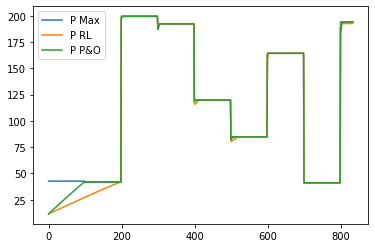

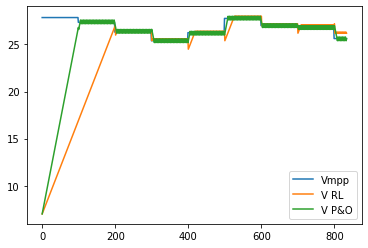

INFO 2020-11-16 09:56:53,419 PO Efficiency=95.54634791857649
INFO 2020-11-16 09:56:53,421 RL Efficiency=91.3071344470415


In [6]:
agent.exp_test_source.play_episode()
test_env.render_vs_true(po=True)

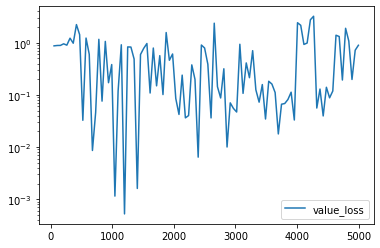

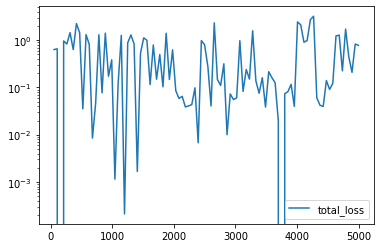

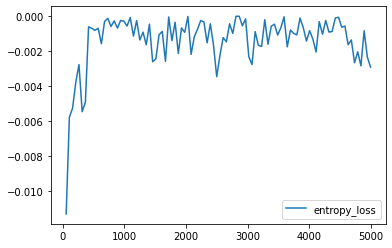

In [7]:
agent.plot_performance(['value_loss', 'total_loss', 'entropy_loss'])